In [1]:
#2024.10.8

import pandas as pd 
import numpy as np
import gc
dfrac = pd.read_csv('./RACs.csv')                  # all MOFs including the theoretical ones
dfgeo = pd.read_csv('./geometric_properties.csv')

In [2]:
dfrac_EMOF=dfrac.iloc[list(np.where(dfrac['DB_num']=='DB14')[0])+list(np.where(dfrac['DB_num']=='DB12')[0])]    # experimentally available MOFs
dfgeo_EMOF=dfgeo.iloc[list(np.where(dfgeo['DB_num']=='DB14')[0])+list(np.where(dfgeo['DB_num']=='DB12')[0])]

In [3]:
#remove unuseful columns
dfrac = dfrac.iloc[:, 1:-10]
dfgeo = dfgeo.iloc[:, 1:-4]
dfrac_EMOF = dfrac_EMOF.iloc[:, 1:-10]
dfgeo_EMOF = dfgeo_EMOF.iloc[:, 1:-4]

In [4]:
# Assuming you have two DataFrames df and dfg with a common column 'filename'
# Merging the DataFrames on 'filename' with inner join to keep only common entries
merged_df = pd.merge(dfrac, dfgeo, on='filename', how='inner')
merged_df_EMOF = pd.merge(dfrac_EMOF, dfgeo_EMOF, on='filename', how='inner')
del dfrac  # Delete the DataFrame
del dfgeo  # Delete the DataFrame
del dfrac_EMOF  # Delete the DataFrame
del dfgeo_EMOF  # Delete the DataFrame
gc.collect()  # Run garbage collection

0

In [5]:
#Remove the columns that has low variance
from sklearn.preprocessing import StandardScaler
import numpy as np

merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(inplace=True)
merged_df_EMOF.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df_EMOF.dropna(inplace=True)

# make sure all the columns are numerical values
# merged_df = merged_df.select_dtypes(include=[np.number])

print(merged_df.shape)

# standardize
scaler = StandardScaler()
scaler.fit(merged_df.drop(columns=['filename']))
# convert the raw data using the standardizing method
scaled_merged_df = scaler.transform(merged_df.drop(columns=['filename']))  #all MOFs
dfEMOF = merged_df_EMOF[merged_df.drop(columns=['filename']).columns]  #experimentally available MOFs
scaled_dfEMOF = scaler.transform(dfEMOF)
# data standardization
df_standardized = pd.DataFrame(scaled_merged_df, columns=merged_df.drop(columns=['filename']).columns)
print(df_standardized.shape)
dfEMOF_standardized = pd.DataFrame(scaled_dfEMOF, columns=dfEMOF.columns)
print(dfEMOF_standardized.shape)

# del merged_df  # Delete the DataFrame
# gc.collect()  # Run garbage collection

# Remove the columns that has low variance
column_to_keep = (df_standardized.std() > 0) # a number that can be ajusted
df_standardized = df_standardized.loc[:, column_to_keep]  
dfEMOF_standardized = dfEMOF_standardized.loc[:, column_to_keep]
print(df_standardized.shape)
print(dfEMOF_standardized.shape)

(472494, 200)
(472494, 199)
(11345, 199)
(472494, 171)
(11345, 171)


In [6]:
#Test if factor analysis is suitable
import pandas as pd
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# # removing low variance columns
# df_standardized = df_standardized.loc[:, df_standardized.std() > 0.05]  # adjustable number

# examining feasibility using some figure of merits
chi_square_value, p_value = calculate_bartlett_sphericity(df_standardized.values)
kmo_all, kmo_model = calculate_kmo(df_standardized.values)

# the results
print("Bartlett's Test Value:", chi_square_value, "P-value:", p_value)
print("KMO Test Value:", kmo_model)



c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\factor_analyzer\factor_analyzer.py:109: RuntimeWarning: divide by zero encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
c:\Users\yibin jiang\Documents\anaconda\envs\pymc_env\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Bartlett's Test Value: inf P-value: 0.0
KMO Test Value: 0.8350236043955536


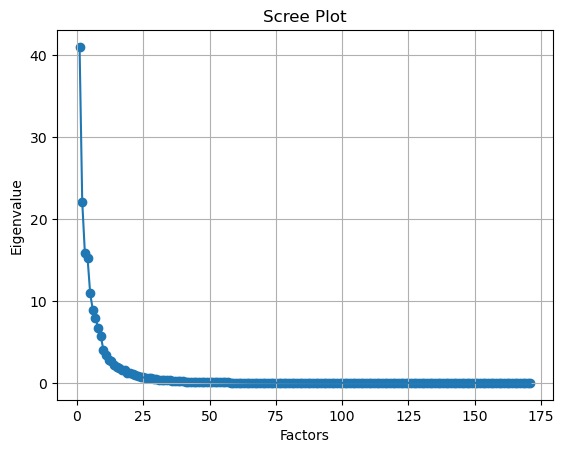

45


In [7]:
from matplotlib import pyplot as plt
# select the number of factors
fa = FactorAnalyzer(rotation=None, n_factors=3, method='minres')
fa.fit(df_standardized.values)

# factor loadings
loadings = fa.loadings_
# print(loadings)

# Scree plot for determining the number of factors

ev, v = fa.get_eigenvalues()
plt.scatter(range(1, df_standardized.shape[1]+1), ev)
plt.plot(range(1, df_standardized.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
#selected the number of factors to consider
consider_threshold = 0.1
Num_factor_selected = sum(ev>consider_threshold)
print(Num_factor_selected)

In [8]:

# initializing the factor
fa = FactorAnalyzer(n_factors=Num_factor_selected, rotation='varimax')  # n_factors is the number of factors，adjustable

# factor analysis
fa.fit(df_standardized.values)  #on all MOFs

# get factor loadings
factor_loadings = fa.loadings_

# convert loadings to DataFrame
columns = [f'Factor{i+1}' for i in range(factor_loadings.shape[1])]
loadings_df = pd.DataFrame(factor_loadings, index=df_standardized.columns, columns=columns)

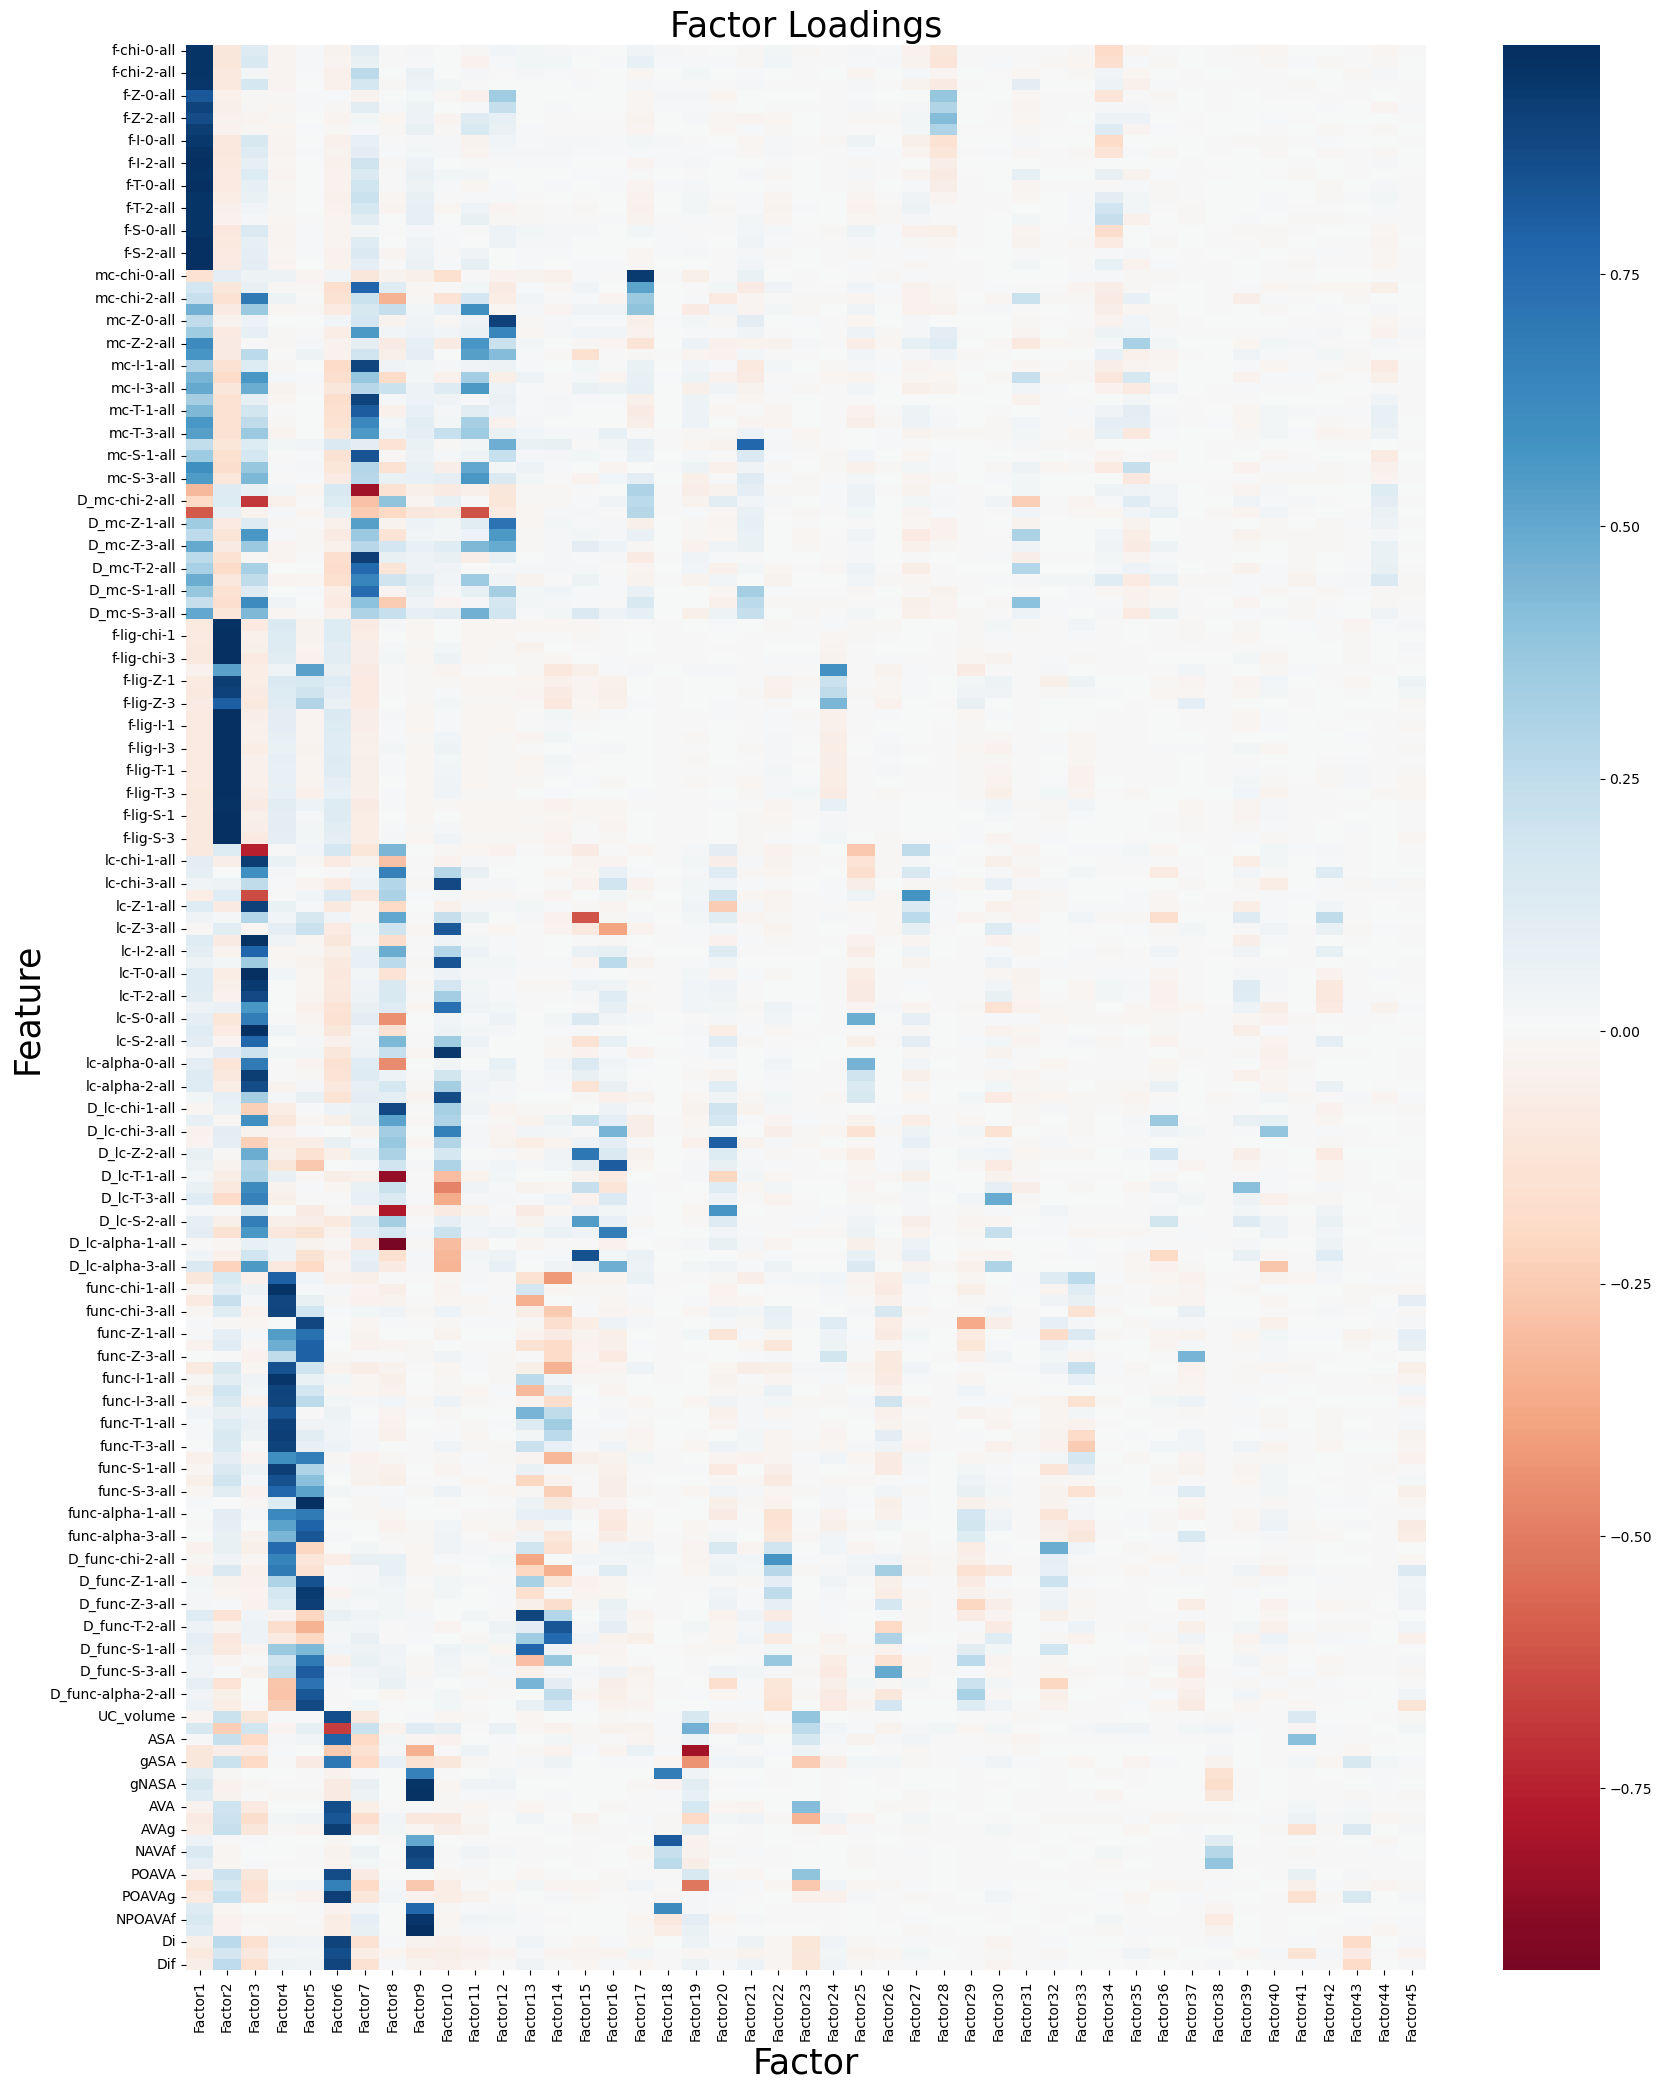

In [9]:
import seaborn as sns
# visualizing factor loadings
plt.figure(figsize=(20, 25))
sns.heatmap(loadings_df, cmap='RdBu', center = 0, annot=False)
plt.title('Factor Loadings', fontsize=25)
plt.xlabel('Factor', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.show()

In [10]:
framework_desc=[]
mc_desc=[]
lc_desc=[]
func_desc=[]
lig_desc=[]
pore_desc=[]
for descriptor in list(loadings_df.index):
    if 'f-lig' in descriptor:
        lig_desc.append(descriptor)
    elif 'f-' in descriptor:
        framework_desc.append(descriptor)
    elif 'mc-' in descriptor:
        mc_desc.append(descriptor)
    elif 'lc-' in descriptor:
        lc_desc.append(descriptor)
    elif 'func' in descriptor:
        func_desc.append(descriptor)
    else:
        pore_desc.append(descriptor)
        
from sklearn.preprocessing import MinMaxScaler
loading_values = (loadings_df.values.T)**2
loading_values = pd.DataFrame(loading_values, columns=loadings_df.index)
categorizing_sum = np.zeros((loadings_df.shape[1],6))
for descriptor in list(loadings_df.index):
    if descriptor in framework_desc:
        categorizing_sum[:,0] += loading_values[descriptor]
    elif descriptor in mc_desc:
        categorizing_sum[:,1] += loading_values[descriptor]
    elif descriptor in lc_desc:
        categorizing_sum[:,2] += loading_values[descriptor]
    elif descriptor in func_desc:
        categorizing_sum[:,3] += loading_values[descriptor]
    elif descriptor in lig_desc:
        categorizing_sum[:,4] += loading_values[descriptor]
    elif descriptor in pore_desc:
        categorizing_sum[:,5] += loading_values[descriptor]

scaler = MinMaxScaler()
categorizing_sum = scaler.fit_transform(categorizing_sum.T).T
categorizing_sum = pd.DataFrame(categorizing_sum, columns=['framework','mc','lc','func','lig','pore'],index=loadings_df.columns)
categorized_descriptors = {'framework':framework_desc,
                           'mc':mc_desc,
                           'lc':lc_desc,
                           'func':func_desc,
                           'lig':lig_desc,
                           'pore':pore_desc}

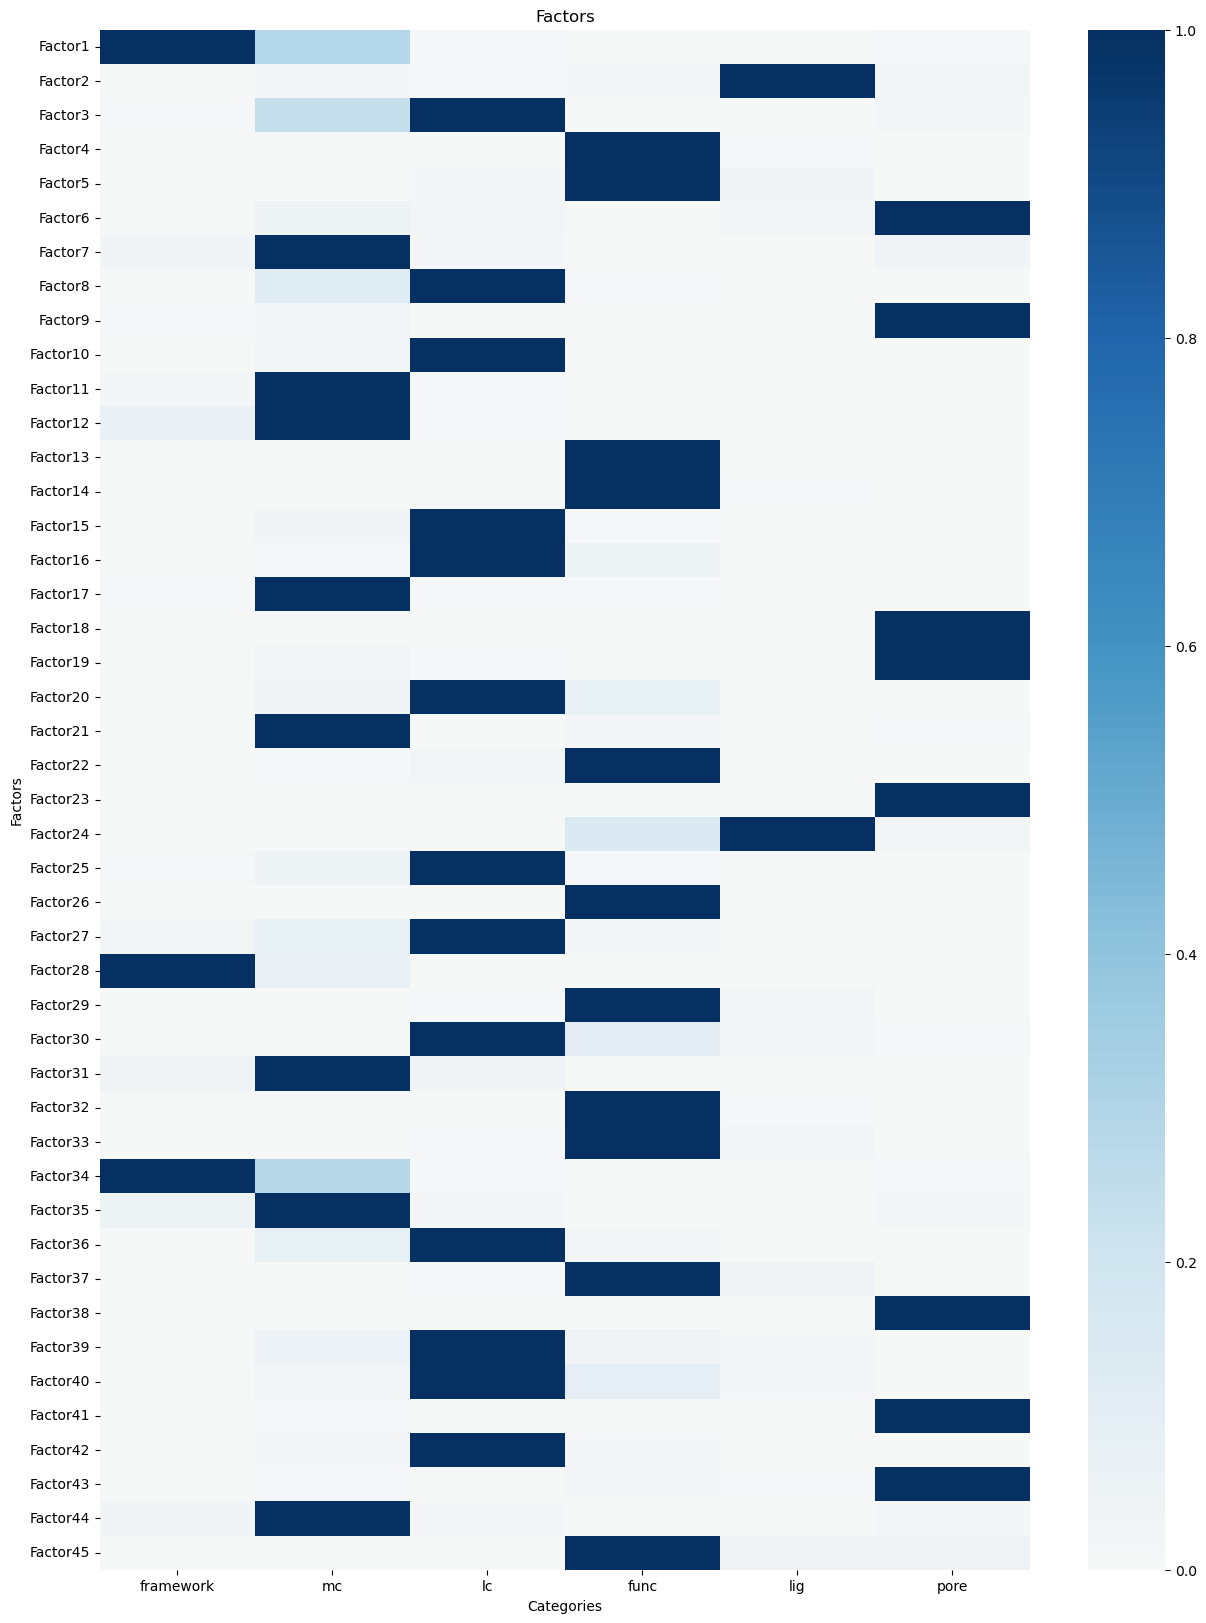

In [11]:
plt.figure(figsize=(15, 20))
sns.heatmap(categorizing_sum, cmap='RdBu', center = 0, annot=False)
plt.title('Factors')
plt.xlabel('Categories')
plt.ylabel('Factors')
plt.show()

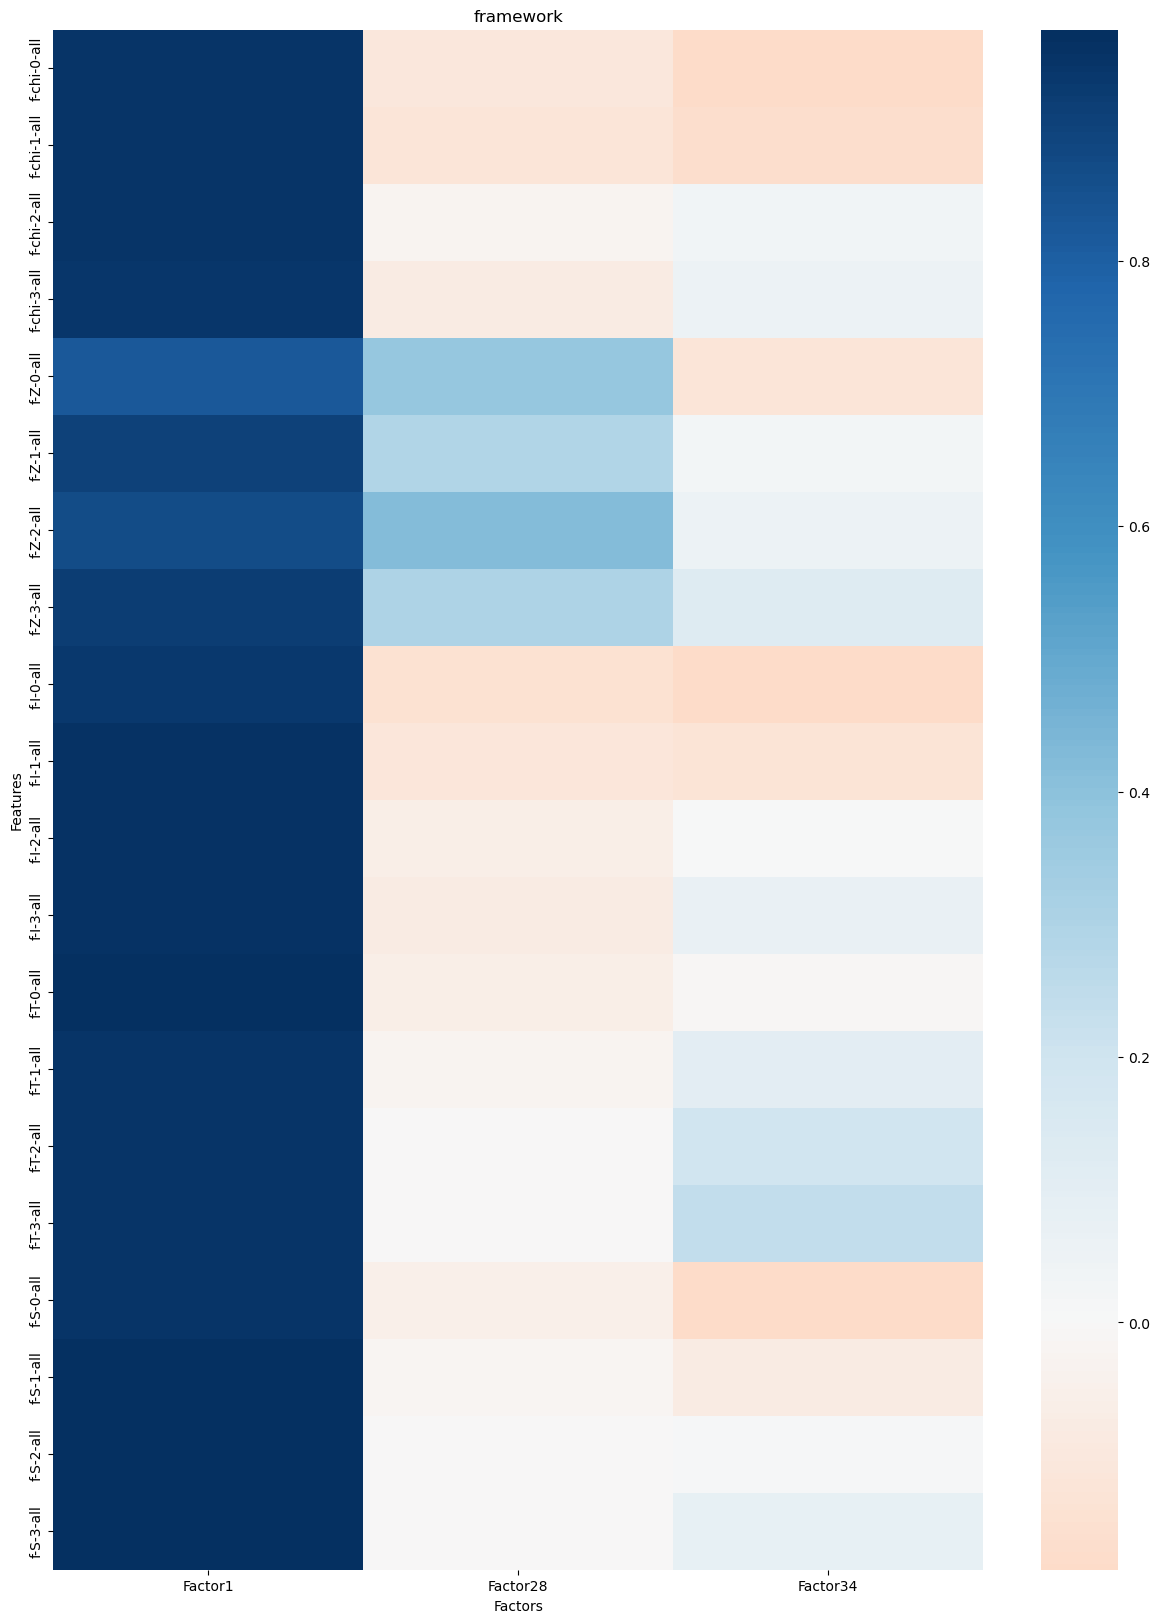

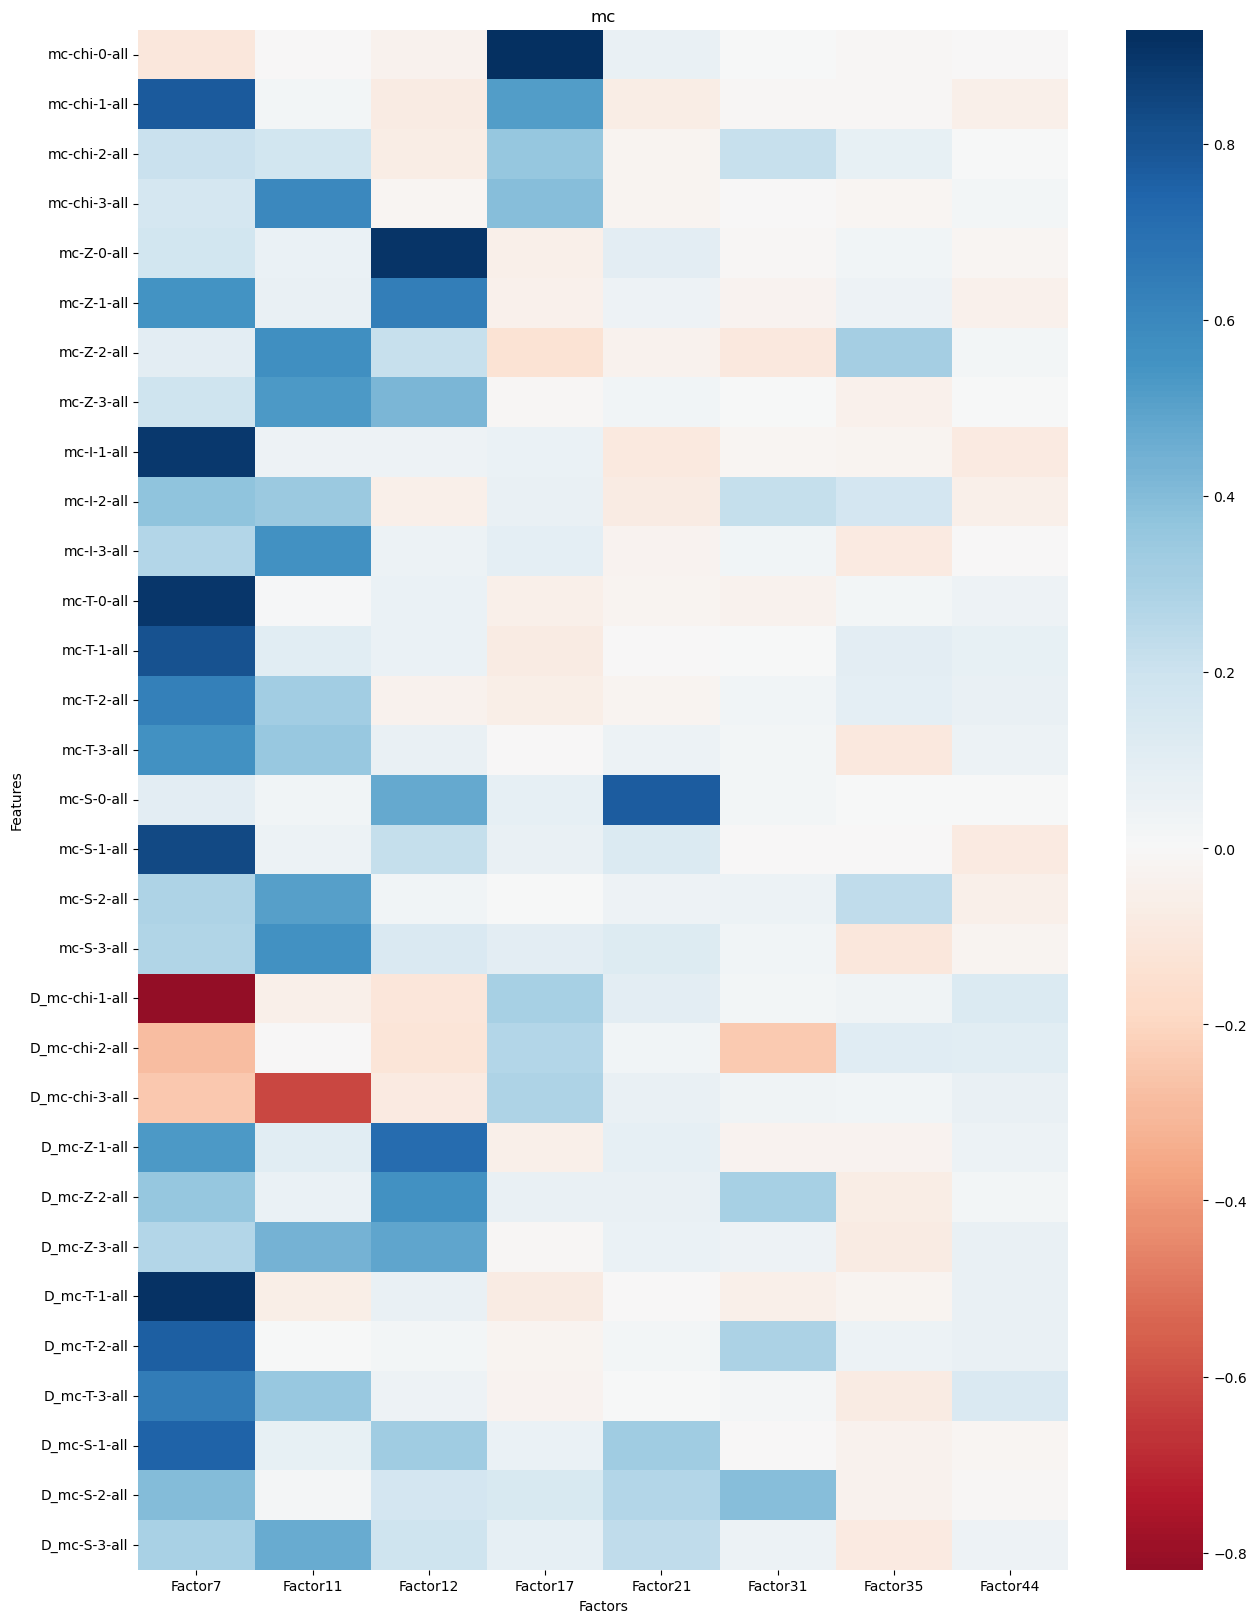

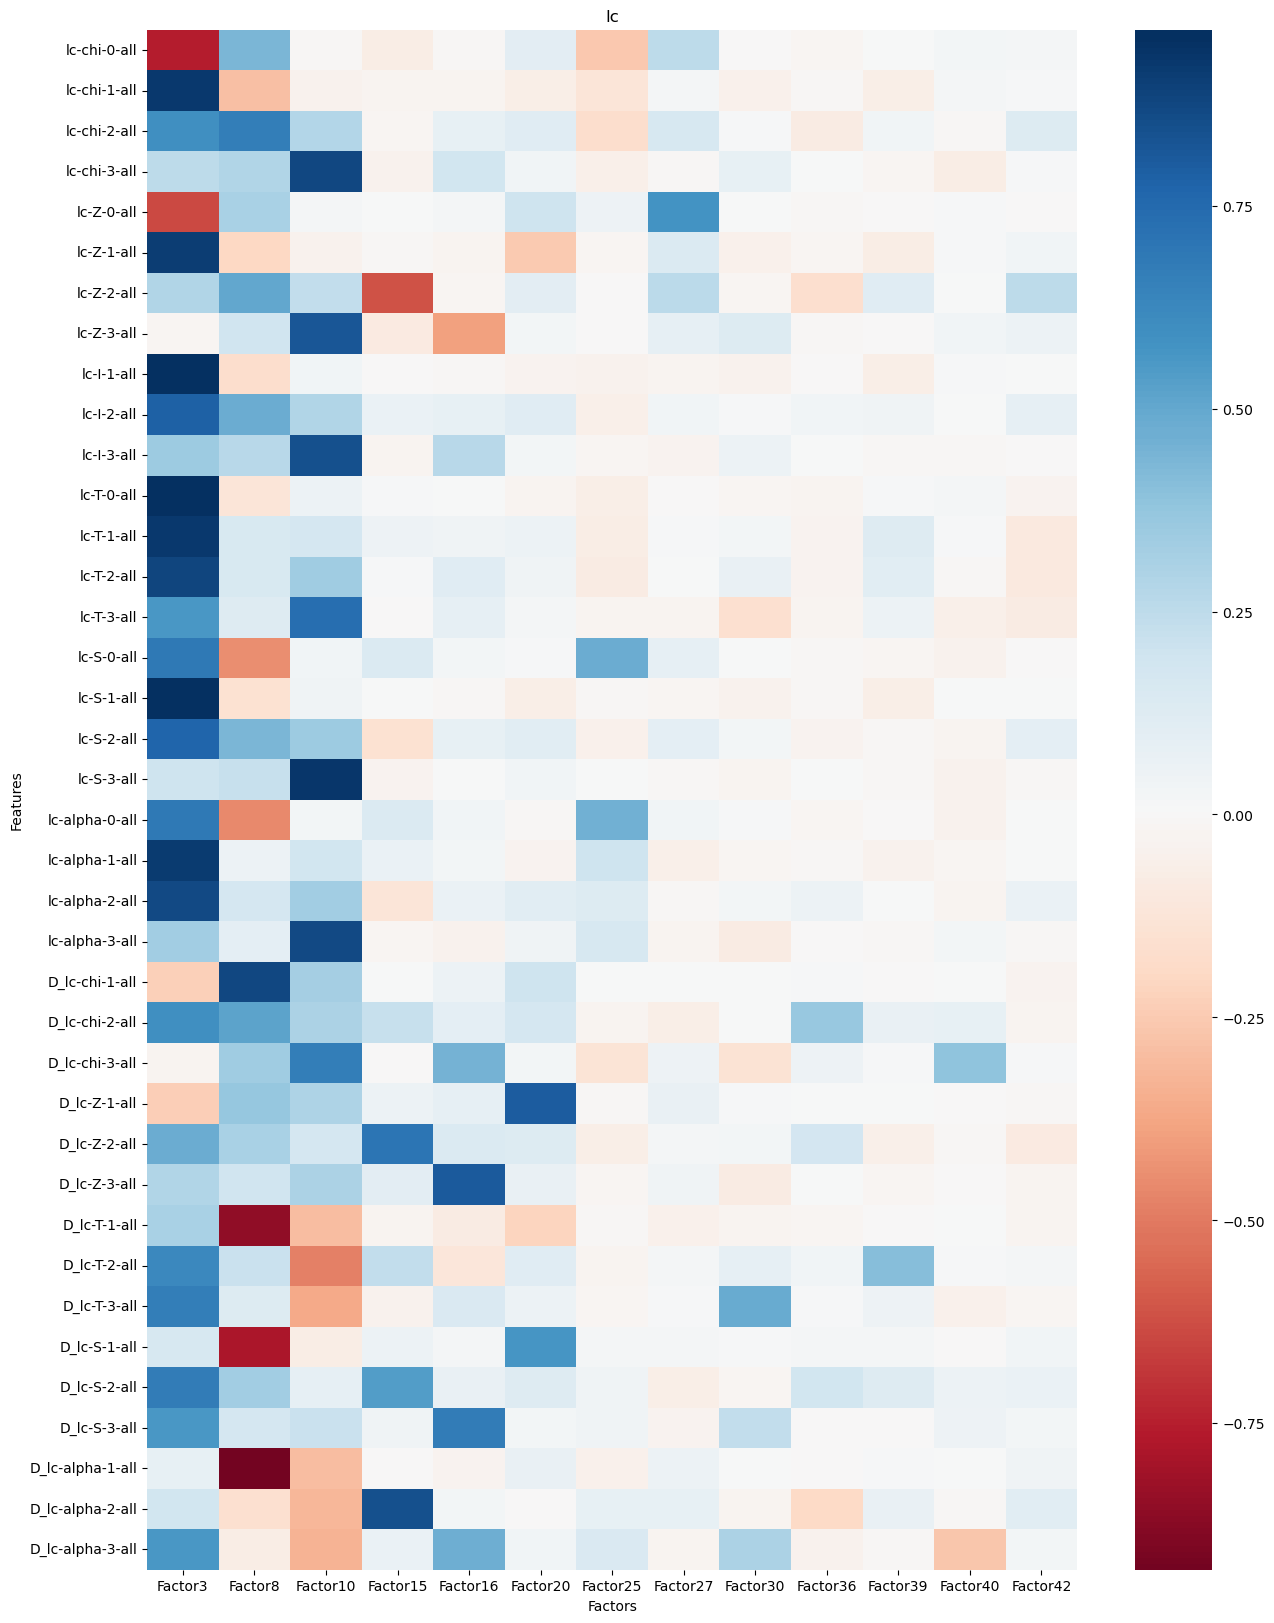

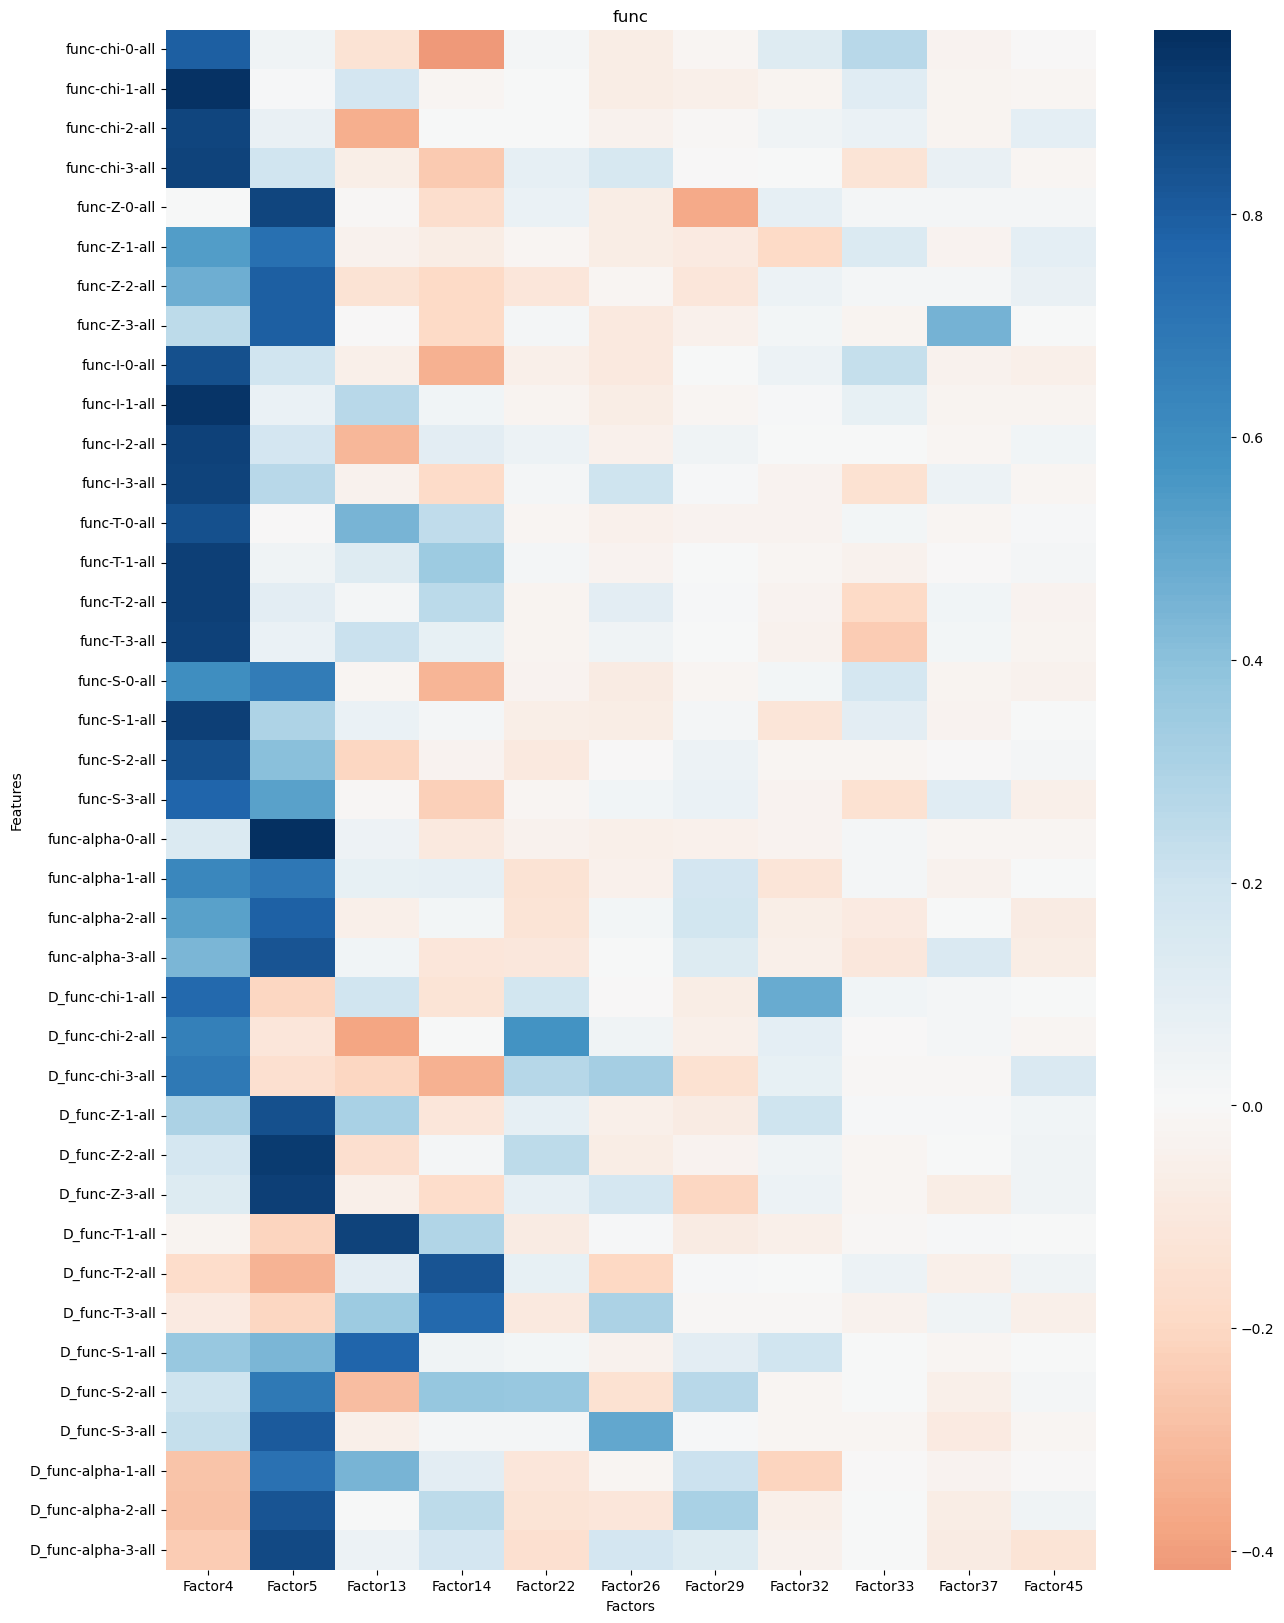

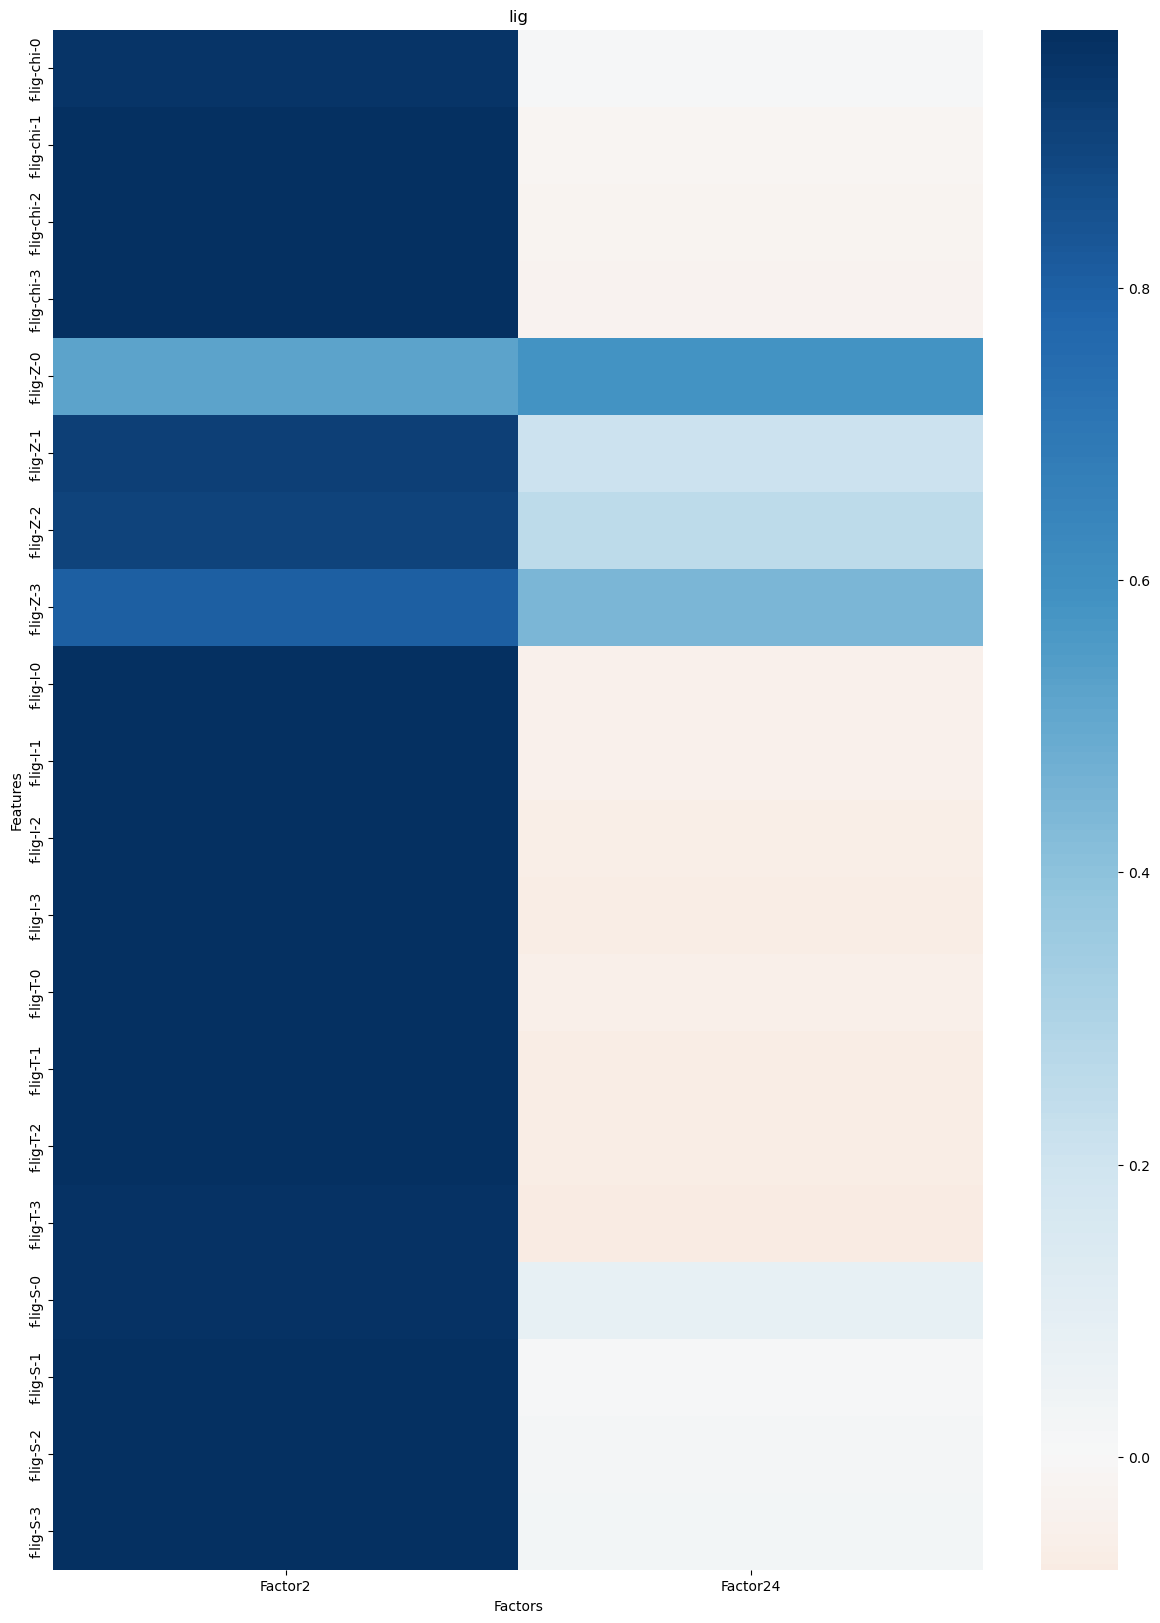

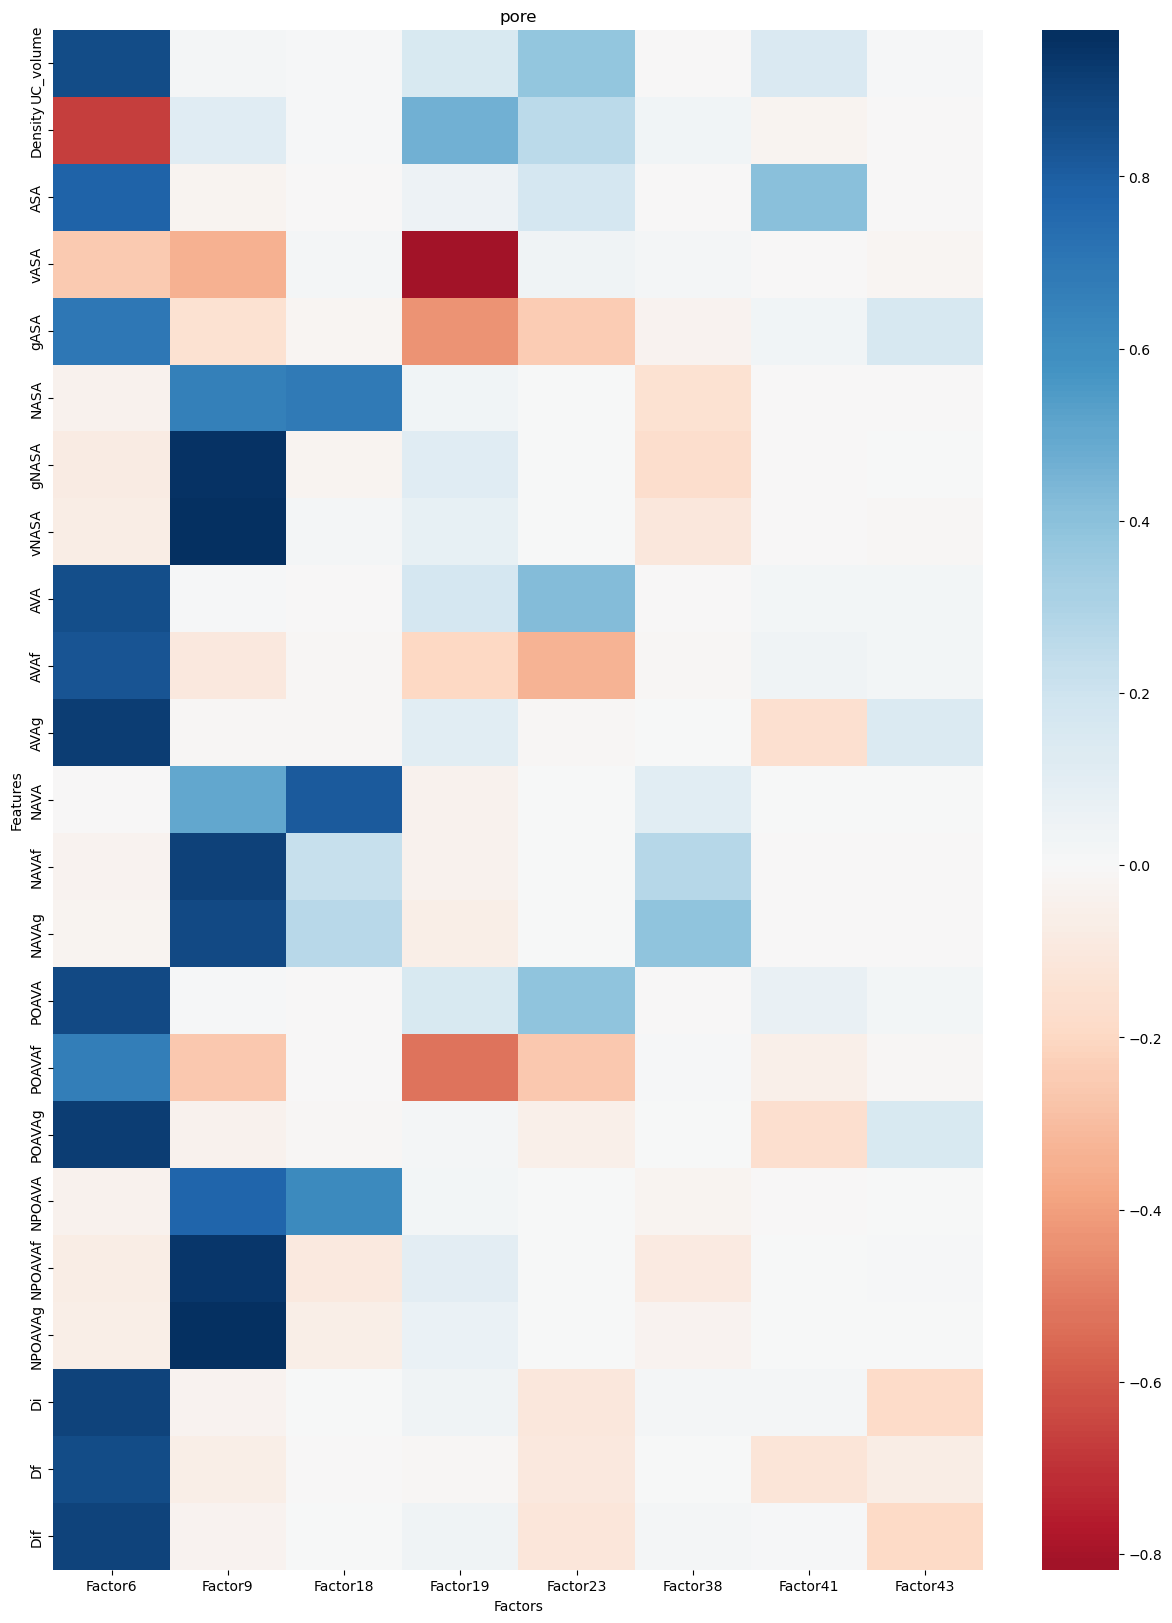

In [12]:
judgement = (categorizing_sum>0.5)
for category in categorizing_sum.columns:
    loading_category = loadings_df.loc[categorized_descriptors[category]][list(judgement[judgement[category]==True].index)]
    plt.figure(figsize=(15, 20))
    sns.heatmap(loading_category, cmap='RdBu', center = 0, annot=False)
    plt.title(category )
    plt.xlabel('Factors')
    plt.ylabel('Features')
    plt.show()

In [13]:
loadings_df.loc[framework_desc][list(judgement[judgement['framework']==True].index)]

,Factor1,Factor28,Factor34
f-chi-0-all,0.948183,-0.109687,-0.185644
f-chi-1-all,0.947701,-0.124180,-0.164323
f-chi-2-all,0.947687,-0.023256,0.033871
f-chi-3-all,0.946046,-0.074169,0.055895
f-Z-0-all,0.821291,0.375205,-0.121477
f-Z-1-all,0.901694,0.294120,0.022387
f-Z-2-all,0.869451,0.422474,0.054942
f-Z-3-all,0.920379,0.300860,0.124436
f-I-0-all,0.936541,-0.148033,-0.186293
f-I-1-all,0.960702,-0.117289,-0.129016
